In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 
%matplotlib inline

### Implement Linear Regression with Numpy only

In [13]:
# load dataset
data = '../data/cars.csv'
df = pd.read_csv(data)
df.head(2)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650


In [4]:
import wrangle as wr

In [14]:
df = wr.rename_columns(df)
df.columns

Index(['make', 'model', 'year', 'engine_fuel_type', 'engine_hp',
       'engine_cylinders', 'transmission_type', 'driven_wheels',
       'number_of_doors', 'market_category', 'vehicle_size', 'vehicle_style',
       'highway_mpg', 'city_mpg', 'popularity', 'msrp'],
      dtype='object')

__Train, validate, test split__

In [15]:
# make the split reproducible
np.random.seed(2912)

n = len(df)

# 20% for validate, 20% for test and 60% for train
n_val = int(0.2 * n)
n_test = int(0.2 * n)
n_train = n - (n_val + n_test)

# shuffle values to make the split random
idx = np.arange(n)
np.random.shuffle(idx)

# rearrange the values inside the dataframe
df_shuffled = df.iloc[idx]

# split with slicing the data
df_train = df_shuffled.iloc[:n_train].copy().reset_index(drop=True)
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy().reset_index(drop=True)
df_test = df_shuffled.iloc[n_train+n_val:].copy().reset_index(drop=True)

In [7]:
df_train.head(2)

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,mercedes-benz,350-class,1991,diesel,134.0,6.0,automatic,rear_wheel_drive,4.0,"diesel,luxury",large,sedan,23,19,617,2178
1,aston_martin,db9,2014,premium_unleaded_(required),510.0,12.0,automatic,rear_wheel_drive,2.0,"exotic,high-performance",midsize,coupe,19,13,259,185800


In [8]:
# check if all element are included in the split
len(df) == len(df_train) + len(df_val) + len(df_test)

True

In [16]:
# separate the target variable and make its logarithmic transformation
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

# drop the target variable from the data sets
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

### Linear Regression

For one single $y$ the formula is $g(x_i) = w_0 + \sum_{j=0}^{n-1} w_j * x_{ij}$, where:
- $w_0$ is bias (if we don't know any other features, the final result will be equal to this number), or `y-intersect` on the graph. 
- $n$ - number of features (we count from 0 like in array, that's why $j=0$ and the count goes till $n-1$, normally we count from 1 till $n$). 
- $w_j$ weight of the $j$ -th feature
- $x_{ij}$ the $j$ -th feature of $i$ -th row

In [22]:
# make up values
xi = [453, 11, 86]
w0 = 5.45 # bias
w = [0.04, -0.1, 0.01] # weights

In [23]:
def linear_regression_1(xi):
    n = len(xi)

    pred = w0
    for j in range(n):
        pred = pred + w[j]*xi[j]
    return pred

In [28]:
pred = linear_regression_1(xi)
pred

23.33

In [25]:
# convert the prediction value (log(y+1)) to price
price = np.expm1(pred)
display(price.round(2))
price == np.exp(pred) - 1

13554711010.88

True

#### Linear regression through vector - vector dot product

In [31]:
def dot(xi, w):
    n = len(xi)
    res = 0
    for j in range(n):
        res = res + xi[j] * w[j]
    return res 

def linear_regression_2(xi):
    return w0 + dot(xi, w)
    # same as
    #return w0 + xi.dot(w)

In [32]:
linear_regression_2(xi)

23.33

In [30]:
w0 + np.array(xi).dot(w)

23.33

We can avoid summing the vector multiplication with $w_0$ by adding $w_0$ in the beginning of the weights array `w` and `1` in the beginning of the features array `xi`

In [46]:
print([w0] + w)
# in numpy
np.insert(w, 0, w0 )

[5.45, 0.04, -0.1, 0.01]


array([ 5.45,  0.04, -0.1 ,  0.01])

In [34]:
[1] + xi

[1, 453, 11, 86]

In [47]:
# np.insert(array_to_insert_to, position, values, axis(for 2D))
w = np.insert(w, 0, w0)
xi = np.insert(xi, 0, 1)

In [48]:
print(w)
print(xi)

[ 5.45  0.04 -0.1   0.01]
[  1 453  11  86]


In [49]:
# make up values
xi = [453, 11, 86]
w0 = 5.45 # bias
w = [0.04, -0.1, 0.01] # weights

In [50]:
def linear_regression_3(xi, w, w0):
    wn = np.insert(w, 0, w0)
    xn = np.insert(xi, 0, 1)
    return xn.dot(wn)


In [51]:
linear_regression_3(xi, w, w0)

23.33

#### Linear regression as matrix-vector dot product

$X * w = y$, where:
- `X` -> matrix with arrays of `n` features with leading 1 as the 1st element
- `w` -> vector(array) with weight with bias `w0` as the st element
- `y` -> vector(array) of predictions

In [57]:
# features matrix
X = np.array([
    [453, 11, 86],
    [365, 20, 76],
    [501, 16, 70],
    [467, 19, 66],
    [398, 21, 72],
    [403, 13, 65],
    [600, 23, 93],
    [388, 14, 80],
    [345, 12, 98]
])
w0 = 5.45 # bias
w = [0.04, -0.1, 0.01] # weights

Dot multiplication matrix `X` with weights `w` -> returns an array of predictions.

`X.dot(w) = y_pred`

In [53]:
# add ones to X
np.insert(X, 0, np.ones(len(X)), axis = 1)

array([[  1, 453,  11,  86],
       [  1, 365,  20,  76],
       [  1, 501,  16,  70],
       [  1, 467,  19,  66],
       [  1, 398,  21,  72],
       [  1, 403,  13,  65],
       [  1, 600,  23,  93],
       [  1, 388,  14,  80],
       [  1, 345,  12,  98]])

In [54]:
# add w0 to w
np.insert(w, 0, w0)

array([ 5.45,  0.04, -0.1 ,  0.01])

In [68]:
X = np.insert(X, 0, np.ones(len(X)), axis = 1)
w = np.insert(w, 0, w0)
# calculate predictionss
X.dot(w)

array([23.33, 18.81, 24.59, 22.89, 19.99, 20.92, 28.08, 20.37, 19.03])

#### Train regression model and calculate weights

`X` -> matrix with dimension `(m, n+1)`, where:
- `m` -> number of rows, 
- `n` -> number of features,
- `n+1` -> adding 1 in the beginning of every feature vector (see above)

We can not create an inverse matrix of `X` because its not squared. If the inverse matrix of `X` existed, we could solve for `w` by multiplying both sides with an inversed matrix: 
- $X^{-1} * X * w = X^{-1} * y$, 
- then $X^{-1} * X$ turnes into identity matrix: $I * w = X^{-1} * y$. 
- As we know from linear algebra, identity matrix multiplied by vector equals that vector $w = X^{-1} * y$.

However can make matrix squared by using dot multiplication with its transposed version, this calls __gram matrix__. $X^T * X * w = X^T * y$, it returns matrix with the shape `(n+1, n+1)`.

In [69]:
X

array([[  1, 453,  11,  86],
       [  1, 365,  20,  76],
       [  1, 501,  16,  70],
       [  1, 467,  19,  66],
       [  1, 398,  21,  72],
       [  1, 403,  13,  65],
       [  1, 600,  23,  93],
       [  1, 388,  14,  80],
       [  1, 345,  12,  98]])

In [67]:
X.shape # m (rows) = 9, n (features) = 3, n+1 = 4

(9, 4)

#### Step 1.
Multiply by sides by transposed matrix `X1.T`

$X^T * X * w = X^T * y$, `y` -> `y_train`

In [70]:
# gram matrix, shape (4, 4)
X.T.dot(X)

array([[      9,    3920,     149,     706],
       [   3920, 1757906,   66141,  308091],
       [    149,   66141,    2617,   11632],
       [    706,  308091,   11632,   56490]])

#### Step 2.
Multiply both sides by __inversed__ gram matrix.

$(X^T * X)^{-1} * X^T * X * w = (X^T * X)^{-1} * X^T * y$

This will turn $(X^T * X)^{-1} * X^T * X$ into __identity matrix__.

In [77]:
gram = X.T.dot(X)
np.linalg.inv(gram).round(2)

array([[ 9.72, -0.01, -0.09, -0.07],
       [-0.01,  0.  , -0.  , -0.  ],
       [-0.09, -0.  ,  0.01,  0.  ],
       [-0.07, -0.  ,  0.  ,  0.  ]])

In [78]:
# get identity matrix
gram.dot(np.linalg.inv(gram)).round(1)

array([[ 1.,  0., -0.,  0.],
       [-0.,  1., -0.,  0.],
       [ 0., -0.,  1.,  0.],
       [-0.,  0., -0.,  1.]])

#### Step 3
Solve for `w`:

$w = (X^T * X)^{-1} * X^T * y$

The first element of `w`, `w[0]` is a bias, the rest are weights.
 
$Predictions = w_0 + w_1 * x_{i1} + w_2 * x_{i2} + ... + w_n * x_{in}$

In [25]:
def train_linear_regression(X_train: np.array, y_train):
    # fit on train
    '''
    Parameters:
        X_train: 2-D array of features
        y_train: 1-D array of target variable
    The function calculates weights for linear regression equation.
    Returns:
        w[0] -> float, bias (y-intersect)
        w[1:] -> array of weights (floats)
    '''
    # add 1 to the beginning of every vector in features
    X = np.insert(X_train, 0, np.ones(len(X_train)), axis = 1)
    # get gram matrix
    XTX = X.T.dot(X)
    # inverse XTX
    XTX_inv = np.linalg.inv(XTX)
    # calculate weights
    w = XTX_inv.dot(X.T).dot(y_train)
    bias = w[0]
    weights = w[1:]

    return bias, weights

In [88]:
# features matrix
X = np.array([
    [453, 11, 86],
    [365, 20, 76],
    [501, 16, 70],
    [467, 19, 66],
    [398, 21, 72],
    [403, 13, 65],
    [600, 23, 93],
    [388, 14, 80],
    [345, 12, 98]
])
y = [24, 56, 78, 91, 34, 22, 74, 45, 63]
w0, w = train_linear_regression(X, y)

In [89]:
y_pred = w0 + X.dot(w)

In [90]:
y_pred

array([46.04800337, 54.42174522, 57.21914082, 59.5100828 , 58.50477151,
       42.34675315, 82.77568893, 45.40231191, 40.77150229])

#### Baseline model (Numeric columns only)

In [17]:
df_train.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders     float64
transmission_type     object
driven_wheels         object
number_of_doors      float64
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
dtype: object

In [21]:
numeric = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
def prepare_X(df: pd.DataFrame, cols: list[str]) -> pd.DataFrame:
    '''
    df: dataframe for the baseline model
    cols: numeric column names
    '''
    df_num = df[cols]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [26]:
X_train = prepare_X(df_train, numeric)
w0, w = train_linear_regression(X_train, y_train)
# for the real price prediction we need to transform back from 
# log to exp with np.expm1(y_pred)
y_pred = w0 + X_train.dot(w)

In [27]:
y_pred

array([ 8.91295088, 11.43349293,  8.98863555, ...,  9.330657  ,
       13.0175407 , 10.45858657])

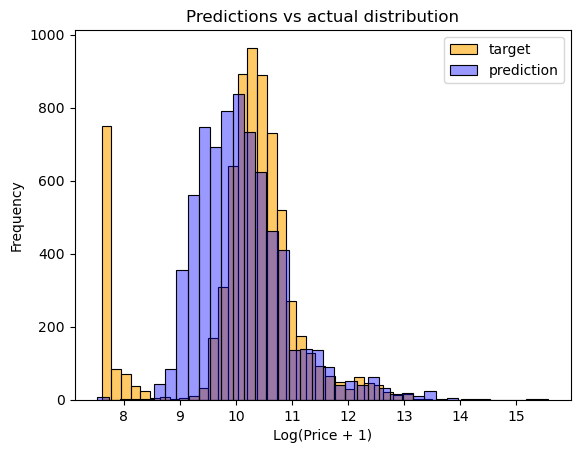

In [29]:
# plot actual vs predictions
sns.histplot(y_train, label='target', color='orange', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.4, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

#### RMSE score

In [30]:
def rmse(y, y_pred):
    ''' 
    y - actual prices
    y_pred - predicted prices

    calculates RMSE score
    '''
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [31]:
rmse(y_train, y_pred)

0.7494514707393684

In [33]:
X_validate = prepare_X(df_val,numeric)
y_pred_val = w0 + X_validate.dot(w)
rmse(y_val, y_pred_val)

0.7749677724415818

Simple feature engineering: calculate the age of cars.

In [44]:
# rewrite prepare, addd age
def prepare_X(df: pd.DataFrame) -> pd.DataFrame:
    '''
    df: dataframe for the baseline model
    cols: numeric column names
    '''
    df = df.copy()
    df['age'] = 2017 - df.year
    cols = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity', 'age']
    df_num = df[cols]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [35]:
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred_val = w0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred_val))

train 0.5128811907596227
validation 0.5188150608818473


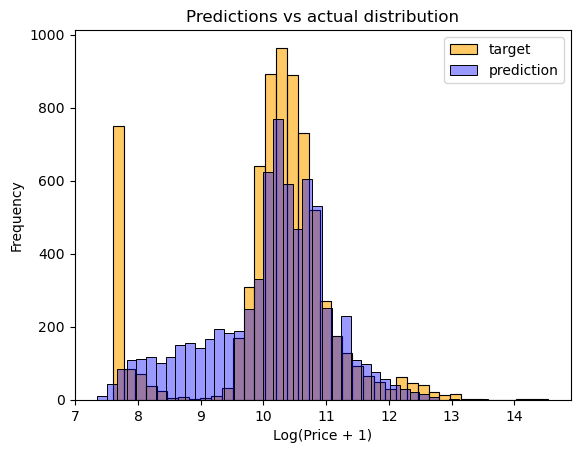

In [36]:
# plot actual vs predictions
sns.histplot(y_train, label='target', color='orange', alpha=0.6, bins=40)
sns.histplot(y_pred, label='prediction', color='blue', alpha=0.4, bins=40)

plt.legend()

plt.ylabel('Frequency')
plt.xlabel('Log(Price + 1)')
plt.title('Predictions vs actual distribution')

plt.show()

#### Categorical variables

In [37]:
df.make.unique()

array(['bmw', 'audi', 'fiat', 'mercedes-benz', 'chrysler', 'nissan',
       'volvo', 'mazda', 'mitsubishi', 'ferrari', 'alfa_romeo', 'toyota',
       'mclaren', 'maybach', 'pontiac', 'porsche', 'saab', 'gmc',
       'hyundai', 'plymouth', 'honda', 'oldsmobile', 'suzuki', 'ford',
       'cadillac', 'kia', 'bentley', 'chevrolet', 'dodge', 'lamborghini',
       'lincoln', 'subaru', 'volkswagen', 'spyker', 'buick', 'acura',
       'rolls-royce', 'maserati', 'lexus', 'aston_martin', 'land_rover',
       'lotus', 'infiniti', 'scion', 'genesis', 'hummer', 'tesla',
       'bugatti'], dtype=object)

In [39]:
df.make.nunique()

48

In [48]:
list(df.make.value_counts().head(5).index)

['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge']

In [45]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

In [49]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
def prepare_X(df: pd.DataFrame) -> pd.DataFrame:
    '''
    df: dataframe for the baseline model
    cols: numeric column names
    '''
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    # got through top-5 car brands
    for v in list(df.make.value_counts().head(5).index):
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    # go through number of doors
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)


    df_new = df[features]
    df_new = df_new.fillna(0)
    X = df_new.values
    return X

In [50]:
# cope paste train model/calculate score
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

y_pred = w0 + X_train.dot(w)
print('train', rmse(y_train, y_pred))

X_val = prepare_X(df_val)
y_pred_val = w0 + X_val.dot(w)
print('validation', rmse(y_val, y_pred_val))

train 0.5026750065739469
validation 0.5075439929907208


In [51]:
# add transmission and engine fuel type
df_train.transmission_type.unique()

array(['automatic', 'manual', 'automated_manual', 'direct_drive',
       'unknown'], dtype=object)

In [52]:
df_train.transmission_type.value_counts() # take top-3 only

automatic           4923
manual              1810
automated_manual     366
direct_drive          40
unknown               11
Name: transmission_type, dtype: int64

In [53]:
df_train.engine_fuel_type.unique()

array(['diesel', 'premium_unleaded_(required)', 'regular_unleaded',
       'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)',
       'flex-fuel_(premium_unleaded_required/e85)', 'electric',
       'flex-fuel_(premium_unleaded_recommended/e85)',
       'flex-fuel_(unleaded/natural_gas)', 'natural_gas', nan],
      dtype=object)

In [57]:
df_train.engine_fuel_type.nunique()

10

In [58]:
df_train.engine_fuel_type.value_counts() # top 4

regular_unleaded                                4281
premium_unleaded_(required)                     1205
premium_unleaded_(recommended)                   937
flex-fuel_(unleaded/e85)                         541
diesel                                            88
electric                                          39
flex-fuel_(premium_unleaded_required/e85)         34
flex-fuel_(premium_unleaded_recommended/e85)      17
flex-fuel_(unleaded/natural_gas)                   3
natural_gas                                        2
Name: engine_fuel_type, dtype: int64

In [59]:
# change prepare

base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
def prepare_X(df: pd.DataFrame) -> pd.DataFrame:
    '''
    df: dataframe for the baseline model
    cols: numeric column names
    '''
    df = df.copy()
    features = base.copy()

    df['age'] = 2017 - df.year
    features.append('age')
    
    # got through top-5 car brands
    for v in list(df.make.value_counts().head(5).index):
        feature = 'is_make_%s' % v
        df[feature] = (df['make'] == v).astype(int)
        features.append(feature)
    
    # go through number of doors
    for v in [2, 3, 4]:
        feature = 'num_doors_%s' % v
        df[feature] = (df['number_of_doors'] == v).astype(int)
        features.append(feature)

    # top-3 transmission
    for v in df.transmission_type.value_counts().head(3):
        feature = 'transmission_%s' % v 
        df[feature] = (df.transmission_type == v).astype('uint8')
        features.append(feature)

    # top-4 engine fuel type
    for v in df.engine_fuel_type.value_counts().head(4):
        feature = 'engine_fuel_%s' % v 
        df[feature] = (df.engine_fuel_type == v).astype('uint8')
        features.append(feature)

    df_new = df[features]
    df_new = df_new.fillna(0)
    X = df_new.values
    return X